# Markov state modeling

We are going to use a more robust way to observe the structure states our protein went through. This will be done by taking frames from the trajectories, analyzing them using a clustering algorithm to generate "states" and then modeling the transitions between states as a Markov Chain (read about them [here](http://msmbuilder.org/3.8.0/msm.html)). This is a common approach to analyzing MD trajectories and is a great way to get started with analyzing your own trajectories.

In doing so we will be building a Markov State Model. You can read more about the background and motivation [elsewhere](http://msmbuilder.org/3.8.0/background.html).

Like stated above, the workflow looks a little something like this: 
![workflow](http://msmbuilder.org/3.8.0/_images/flow-chart.png)

To make MSM, there are many libraries out there that have been developed, but sadly only a few of them are supported still. 
The original was called MSMBuilder from Stanford, developed in Vijay Pande's group in 2007. 
Since then, many other options such as PyEmma and DeepTime were developed, but those are also no longer supported. 

Recent efforts have tried ressurrecting MSMBuilder have resulted in two major repositories receiving updates: 
1. [Enspara](https://github.com/bowman-lab/enspara), from Greg Bowman's group at UPenn
2. [MSMBuilder-2022](https://github.com/msmbuilder/msmbuilder2022), an updated version of 
the original MSMBuilder being supported by Xuhui Huang (University of Wisconsin-Madison) 

For this notebook we'll use `MSMBuilder-2022`
 we'll first need to install MSMBuilder, used by the Folding@home labs. To do this:\
`conda install -c conda-forge testmsm `

In [12]:
# import MSMBuilder
import msmbuilder as msm
import numpy as np
from matplotlib import pyplot as plt
# for quality of life, lets just suppress the warnings in this example: 
import warnings
warnings.filterwarnings('ignore')

Building an MSM requires a _lot_ more than a single trajectory, so instead of generating a lot more data, we will just download and hold some trajectories in memory.

In [3]:
# Download example dataset
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide(verbose=False)
xyz = fs_peptide.get().trajectories
print(fs_peptide.description())

This dataset consists of 28 molecular dynamics trajectories of Fs peptide
(Ace-A_5(AAARA)_3A-NME), a widely studied model system for protein folding.
Each trajectory is 500 ns in length, and saved at a 50 ps time interval (14
us aggegrate sampling). The simulations were performed using the AMBER99SB-ILDN
force field with GBSA-OBC implicit solvent at 300K, starting from randomly
sampled conformations from an initial 400K unfolding simulation. The
simulations were performed with OpenMM 6.0.1.

The dataset, including the script used to generate the dataset
is available on figshare at

http://dx.doi.org/10.6084/m9.figshare.1030363



To speed things up, we will also subsample our trajectories by taking every 10 frames

In [4]:
xyz = [t[::10] for t in xyz]
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

28 trajectories
with length {500.0} ns


Like stated above, we're still going to follow the workflow of:\
1. Featurize
2. Cluster
3. Analyze

In our case here, the feature we will use will be the Pairwise RMSD.

Pairwise RMSD is effectively computing the RMSD between a set of atoms across every pair of frames in the trajectory.
The RMSD is also computed in the `first_simulation.ipynb` notebook but, briefly: 
RMSD tells us how structurally distinct each of the frames are from one another 
and allows us to cluster based on the most structurally distinct states. RMSD effectively 
measures the the average distance between the atoms of superimposed proteins. 

The actual equation of calculating RMSD is effectively equivalent to an L2 distance, but the RMSD 
calculation process is a bit more involved:
1. Translating and rotating the structures to achieve optimal superpositioning
2. Calculating the root mean square deviation between the atoms of the two superimposed 
coordinates. 

The actual equation to compute an RMSD is: 
$$
RMSD = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - y_i)^2}
$$

Where $x_i$ and $y_i$ are the coordinates of the atoms in the two structures being compared.

In [5]:
from msmbuilder.featurizer import RMSDFeaturizer
backbone_inds = xyz[0].top.select('backbone')
featurizer = RMSDFeaturizer(reference_traj=xyz[0], atom_indices=backbone_inds)
rmsd_feats = featurizer.fit_transform(xyz)
print(xyz[0].xyz.shape)
print(rmsd_feats[0].shape)

(1000, 264, 3)
(1000, 1000)


To prevent any outlier/really far apart frames from really screwing with our numerical analysis, 
we will use a RobustScaler to allow us to scale the data in a way that is robust to outliers.

In [6]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_rmsds = scaler.fit_transform(rmsd_feats)

print(rmsd_feats[0].shape)
print(scaled_rmsds[0].shape)

(1000, 1000)
(1000, 1000)


So this is a lot of data! And that's great! We could cluster it as is (see a few cells below),
or we could try an additional step of Dimensionality Reduction where we try and take our 
million features and reduce them down to some number of components. This reduction is useful also because
some of these million features are going to be redundant and not actually provide any new information.

One common way this is done is by PCA (principal component analysis) which projects the frames along the directions of greatest variance.
However, a more robust way to do this is to go after the kinetically slowest directions of the data, which is what TICA (time-lagged independent component analysis) does. 
Below, we will use TICA projection to generate 4 components that we project all of our simulation frames along.:

In [7]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model.fit(rmsd_feats)
tica_trajs = tica_model.transform(rmsd_feats)

print(rmsd_feats[0].shape)
print(tica_trajs[0].shape)

(1000, 1000)
(1000, 4)


And now we will cluster our data based on this TICA projection. Note that we don't _have_ to use the `tica_trajs` for clustering. We could easily do our clustering on the `rmsd_feats` data itself directly, but that may be noisier and harder to extract meaningful clusters from.

There are many types of clustering algorithms, and you are encouraged to look up the many ways people cluster trajectories.
For the sake of speed and simplicity, we will utilize a `KCenters` clustering algorithm, which was one of the original ways of clustering 
MD trajectories when MSMBuilder was first developed. There are many ways to do this, and if this takes too long on your machine, feel free to replace it with `MiniBatchKMeans`

In [8]:
from msmbuilder.cluster import MiniBatchKMeans,KCenters
clusterer = KCenters(n_clusters=12, random_state=42)
clustered_trajs = clusterer.fit_transform(tica_trajs)

Let's try visualizing our clustering a little bit! 
We can do this by plotting the TICA projection of our data and coloring each point by the cluster it belongs to.

Text(0, 0.5, 'tIC 2')

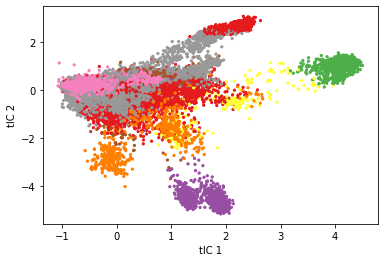

In [35]:
# plot each frame along the first two tICA components colored by cluster assignment

plt.figure()
for i, traj in enumerate(tica_trajs):
    plt.scatter(traj[:, 0], traj[:, 1], c=clustered_trajs[i], cmap='Set1', s=5)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')



Note that ultimately the axes we plot along are the TICs (or Time-Independent Components) that we projected our data along.
This means that each axis isn't just one feature or geometric component, but rather represents some motion that was detected in the data.
In our case, tic0 is the x-axis and is our "slowest" motion, and tic1 is our y-axis and is our "second slowest" motion.

We will also include a colorbar to show where frames are in the trajectory, and we can color points by the density of the region.

Lastly, we can plot the location of each cluster center (ie a representative structure of our cluster) relative to the rest of the projection.

Text(0, 0.5, 'tIC 2')

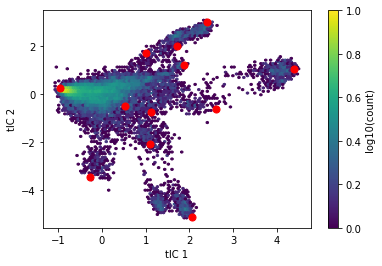

In [36]:
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
# sns.displot(x=txx[:,0], y=txx[:,1], log_scale=True)
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1],
            s=50, c='r')
# include a colorbar based on the hexbin plot
plt.colorbar(label='log10(count)')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')

Now that we have our components, we can build a Markov Model. 
We will do this be defining a lag time (ie number of frames to skip to ensure Markovanaity)

Note that we're going to get a message saying that our MSM contains 1 strongly connected componnet
with 100% of the population. This is a good thing! 

It means that our MSM is ergodic and that we can trust the results we get from it. This is because a
"strongly connected component" refers to the subset of states where every state can be reached
from every other state following transitions with probability greater than some weight (`0.5` 
in our case).

Note that this is very much an *idealized* scenario: We've constructed a well-connected MSM
from a small amount of data on av ery small system. In practice, you may need to do a lot more
work to ensure that your MSM is well-connected and ergodic.



In [37]:
from msmbuilder.msm import MarkovStateModel
msm_fit = MarkovStateModel(lag_time=2, n_timescales=20)
msm_fit = MarkovStateModel(lag_time=2, n_timescales=20)
msm_fit.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(lag_time=2, n_timescales=20)

In [38]:
assignments = clusterer.partial_transform(txx)
assignments = msm_fit.partial_transform(assignments)

Now let's plot our cluster centers but color them according to their population!

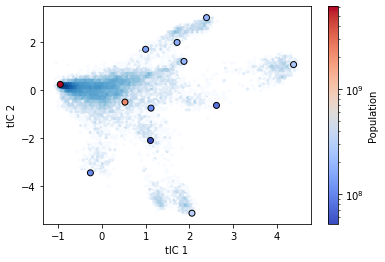

In [45]:
from matplotlib.colors import LogNorm

hb = plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='Blues')

plt.scatter(clusterer.cluster_centers_[msm_fit.state_labels_, 0],
            clusterer.cluster_centers_[msm_fit.state_labels_, 1],
            c=1e10 * msm_fit.populations_,       # color by population
            norm=LogNorm(),                  # use a log color scale
            cmap='coolwarm', edgecolors='black')

plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.colorbar(label="Population")

Our lagtime here was defined arbitrarily for the sake of example but lets sanity check ourselves. 
We can plot the "timescales" of our MSM, which uses the eigendecomposition of the Markov Model to tell us how long it takes for the system to transition between states. 
We would plot these timescales as a function of different lagtimes to see how long it takes for the system to transition between states.

Ideally we want the timescales to be relatively flat (linear is okay) as a function of lagtime,
which would indicate that our lagtime is in the "slow" regime of the system. Let's briefly 
get into some details about what this means: An implied timescales plot is an important diagnostic
for MSM validation. 

Whe we say that "timescale" is "relatively flat" - this means that that the estimated 
timescale of a process (how long it takes to occur) changes very little as we vary the lag 
time. This stability suggests that the model has captured the true dynamics of the system 
well enough that its predictions are not sensitive to the exact choice of lag time, 
within a reasonable range.

When we talk about being in a "slow" regime, we mean that the lag time is long enough that
we are able to capture the slowest processes in the system. If the lag time is too short,
we may miss the slowest processes and the timescales will be artificially short. Being
in a slow regime is ideal becaues this is where the MSM is most informative about our system
and is identifying the largest, and potentially most meaningful, structural changes or transition.

Let's observe our timescales below by plotting it from the `msm` object directly. 
We can see that our lagtime is indeed in the "slow" regime of the system, and 
that we have a few slow timescales that we can use to describe our system.

We alo see an "elbow" indicating slowdown around a lagtime of 2 (which is what we used).
This tells us that while our lagtime of 2 is a bit less Markovian than something like 6, we are still in the "slow" regime of the system.
Ultimately choosing a higher lagtime to ensure Markovianity is a tradeoff between how Markovian we want our model to be and how much data we have to build our model with. A higher lagtime means more data is skipped in the process of MSM construction.

Text(0, 0.5, 'Timescale (steps)')

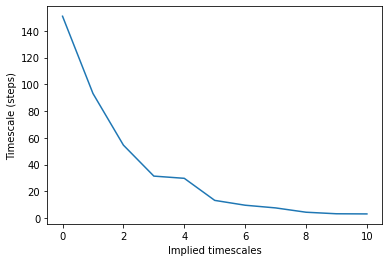

In [42]:
plt.plot(msm_fit.timescales_)
plt.xlabel('Implied timescales')
plt.ylabel('Timescale (steps)')


We can also plot the stationary distribution of our MSM, which tells us the relative populations of each state.


Text(0, 0.5, 'Population')

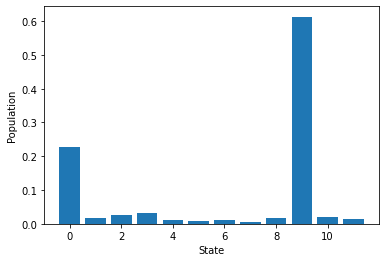

In [46]:
plt.bar(np.arange(msm_fit.n_states_),msm_fit.populations_)
plt.xlabel('State')
plt.ylabel('Population')


Looks like two major states are present in our MSM! The states correspond to index 0 and 9.
Let's take those labels and extract them.

Our `clusterer` object stores indexes of the frames that belong to each cluster. Importantly it also stores the cluster centers, which are representative points for each cluster. Our cluster centers are stored in tICA space (because that's what we clusterd on),
so it'll take a quick extra step to retraverse the original trajectories to get the frames we are looking for.

First let's print out the frames/indexes from `txx` that corresopnd to each cluster center:

In [264]:
print(clusterer.cluster_ids_)

[23654, 20497, 15601, 24328, 24860, 15321, 107, 420, 773, 5241, 23467, 20070]


Now lets define a method that will traverse all of the trajectories until we arrive at the 
desired index. This is not the most efficient way to traverse to the frame we desire, so feel free to try your own way to do this!

In [265]:
def traverse_to_index(list_of_arrays, designated_index):
    count = 0
    for arr in list_of_arrays:
        for item in arr:
            if count == designated_index:
                return item
            count += 1
    raise ValueError("Designated index exceeds total number of elements")

Now lastly, we will extract the MDTraj objects for center 0 and center 9

In [266]:
center_0 = traverse_to_index(xyz, clusterer.cluster_ids_[0])
center_9 = traverse_to_index(xyz, clusterer.cluster_ids_[9])

center_0.save_pdb('center_0.pdb')
center_9.save_pdb('center_9.pdb')

If you have NGL view, we can even visualize these two states side by side! (You can install using `conda install nglview`)

In [ ]:
center_strucs = [traverse_to_index(xyz, cluster_id) for cluster_id in clusterer.cluster_ids_]

For convenience, let's create a single `MDTraj` objects where we join together the state centers 
extracted above.

In [276]:
import mdtraj as md
center_strucs=md.join(center_strucs)

Now, using NGLView, we can visualize them.

In [ ]:
import nglview as nv
view = nv.show_mdtraj(center_strucs)
view

NGLWidget(max_frame=11)